<a href="https://colab.research.google.com/github/thejesht/machine_learning_projects/blob/main/Experiment_3_SentimentNumerical_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [135]:
#importing libraries required for analysis
import pandas as pd
import numpy as np
import re
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt

In [136]:
#importing tweet dataset acquired using tweet scrapper built
df=pd.read_csv('20210815_btc_tweets.csv')
#exploring dimensions of imported dataset
df.shape 

(28854, 36)

In [137]:
#visualising imported dataset
df.head()

,id,conversation_id,created_at,date,time,timezone,user_id,username,name,place,tweet,language,mentions,urls,photos,replies_count,retweets_count,likes_count,hashtags,cashtags,link,retweet,quote_url,video,thumbnail,near,geo,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest
0,1413396249546563586,1413355442475085825,2021-07-09 08:15:00 GMT Daylight Time,2021-07-09,08:15:00,100,44196397,elonmusk,Elon Musk,NaN,@MattWallace888 BTC &amp; ETH are pursuing a m...,en,[],[],[],7005,6712,27392,[],[],https://twitter.com/elonmusk/status/1413396249...,False,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{'screen_name': 'MattWallace888', 'name': 'Ma...",NaN,NaN,NaN,NaN
1,1404132183254523905,1404045922674302982,2021-06-13 18:42:54 GMT Daylight Time,2021-06-13,18:42:54,100,44196397,elonmusk,Elon Musk,NaN,@Cointelegraph This is inaccurate. Tesla only ...,en,[],[],[],10126,10893,54738,[],[],https://twitter.com/elonmusk/status/1404132183...,False,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{'screen_name': 'Cointelegraph', 'name': 'Coi...",NaN,NaN,NaN,NaN
2,1401091921746006017,1400560049358094340,2021-06-05 09:21:59 GMT Daylight Time,2021-06-05,09:21:59,100,44196397,elonmusk,Elon Musk,NaN,@lexfridman @VitalikButerin @ethereum @Bitcoin...,en,[],[],[],2065,3309,24705,[],[],https://twitter.com/elonmusk/status/1401091921...,False,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{'screen_name': 'lexfridman', 'name': 'Lex Fr...",NaN,NaN,NaN,NaN
3,1397626694609956864,1397625459437826049,2021-05-26 19:52:25 GMT Daylight Time,2021-05-26,19:52:25,100,44196397,elonmusk,Elon Musk,NaN,@BTC_Archive 🤣🤣,und,[],[],[],921,330,8609,[],[],https://twitter.com/elonmusk/status/1397626694...,False,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{'screen_name': 'BTC_Archive', 'name': 'Bitco...",NaN,NaN,NaN,NaN
4,1394170030741413888,1394051036462071808,2021-05-17 06:56:52 GMT Daylight Time,2021-05-17,06:56:52,100,44196397,elonmusk,Elon Musk,NaN,"@BTC_Archive To clarify speculation, Tesla has...",en,[],[],[],18117,17855,101526,[],[],https://twitter.com/elonmusk/status/1394170030...,False,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{'screen_name': 'BTC_Archive', 'name': 'Bitco...",NaN,NaN,NaN,NaN


In [138]:
#exploring for null values in imported dataset
df.isnull().sum()

id                     0
conversation_id        0
created_at             0
date                   0
time                   0
timezone               0
user_id                0
username               0
name                   0
place              28854
tweet                  0
language               0
mentions               0
urls                   0
photos                 0
replies_count          0
retweets_count         0
likes_count            0
hashtags               0
cashtags               0
link                   0
retweet                0
quote_url          26172
video                  0
thumbnail          17393
near               28854
geo                28854
source             28854
user_rt_id         28854
user_rt            28854
retweet_id         28854
reply_to               0
retweet_date       28854
translate          28854
trans_src          28854
trans_dest         28854
dtype: int64

In [139]:
#filtering fields from dataset which shall be used for further analysis 
df= df.filter(items=['date', 'time','username','tweet','replies_count','retweets_count','likes_count'])
df.head()

,date,time,username,tweet,replies_count,retweets_count,likes_count
0,2021-07-09,08:15:00,elonmusk,@MattWallace888 BTC &amp; ETH are pursuing a m...,7005,6712,27392
1,2021-06-13,18:42:54,elonmusk,@Cointelegraph This is inaccurate. Tesla only ...,10126,10893,54738
2,2021-06-05,09:21:59,elonmusk,@lexfridman @VitalikButerin @ethereum @Bitcoin...,2065,3309,24705
3,2021-05-26,19:52:25,elonmusk,@BTC_Archive 🤣🤣,921,330,8609
4,2021-05-17,06:56:52,elonmusk,"@BTC_Archive To clarify speculation, Tesla has...",18117,17855,101526


In [140]:
#exploring null values post filtering of required fields for analysis
df.isnull().sum()

date              0
time              0
username          0
tweet             0
replies_count     0
retweets_count    0
likes_count       0
dtype: int64

In [141]:
#creating time stamp 'date'
df.loc[:,'date'] = pd.to_datetime(df.date.astype(str)+' '+df.time.astype(str))
df.drop(columns=['time'], inplace= True)
df['date'] = df['date'] - pd.to_timedelta(df['date'].dt.second, unit='s')
df.head()

,date,username,tweet,replies_count,retweets_count,likes_count
0,2021-07-09 08:15:00,elonmusk,@MattWallace888 BTC &amp; ETH are pursuing a m...,7005,6712,27392
1,2021-06-13 18:42:00,elonmusk,@Cointelegraph This is inaccurate. Tesla only ...,10126,10893,54738
2,2021-06-05 09:21:00,elonmusk,@lexfridman @VitalikButerin @ethereum @Bitcoin...,2065,3309,24705
3,2021-05-26 19:52:00,elonmusk,@BTC_Archive 🤣🤣,921,330,8609
4,2021-05-17 06:56:00,elonmusk,"@BTC_Archive To clarify speculation, Tesla has...",18117,17855,101526


In [142]:
#explornig length of field:tweet, prior to data wrangling 
df['pre_clean_len'] = [len(t) for t in df.tweet]
df.head()

,date,username,tweet,replies_count,retweets_count,likes_count,pre_clean_len
0,2021-07-09 08:15:00,elonmusk,@MattWallace888 BTC &amp; ETH are pursuing a m...,7005,6712,27392,303
1,2021-06-13 18:42:00,elonmusk,@Cointelegraph This is inaccurate. Tesla only ...,10126,10893,54738,286
2,2021-06-05 09:21:00,elonmusk,@lexfridman @VitalikButerin @ethereum @Bitcoin...,2065,3309,24705,148
3,2021-05-26 19:52:00,elonmusk,@BTC_Archive 🤣🤣,921,330,8609,15
4,2021-05-17 06:56:00,elonmusk,"@BTC_Archive To clarify speculation, Tesla has...",18117,17855,101526,67


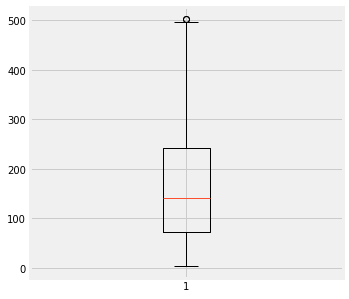

In [143]:
#plotting distribution of length of tweets prior to data wrangling
fig, ax = plt.subplots(figsize=(5, 5))
plt.boxplot(df.pre_clean_len)
plt.show()

In [144]:
#it is worth noting that twitter platform allows only 280 charecters to be present in the tweet, however in dataset we had imported we find close to 12% of entries that contain more than 280 charecters. Hence it is required we perform data wrangling to remove unwanted information.
x= df[df.pre_clean_len > 280]
len(x)/len(df)

0.11970610660566992

In [145]:
#sorting dataset by timestamp metric 'date'
df.sort_values(by=['date'], inplace=True, ascending=True)
df.reset_index(drop=True, inplace=True)
df.head()

,date,username,tweet,replies_count,retweets_count,likes_count,pre_clean_len
0,2020-01-01 08:32:00,nebraskangooner,@PhilipEytan Almost as useless as your tweet a...,1,0,2,122
1,2020-01-01 11:30:00,petermccormack,"@walshjonwalsh In the reports, I account for i...",1,0,3,179
2,2020-01-01 14:51:00,100trillionusd,@BrendanLane0 Good eye. Yes I used the origina...,5,5,88,293
3,2020-01-01 15:29:00,coryklippsten,@gauravdahake @bitdroplet @cryptovill_es @pier...,2,0,1,298
4,2020-01-01 22:09:00,woonomic,"@henriqueztony @NexoFinance No, because it has...",3,2,10,260


In [146]:
#data wrangling function to remove unwanted information from acquired tweets 
plt.style.use('fivethirtyeight')
%matplotlib inline
#importing required libraries 
import re
from bs4 import BeautifulSoup
from nltk.tokenize import WordPunctTokenizer
#initilising tokenizer
tok = WordPunctTokenizer()

pat1 = r'@[A-Za-z0-9_]+'
pat2 = r'https?://[^ ]+'
combined_pat = r'|'.join((pat1, pat2))
www_pat = r'www.[^ ]+'
negations_dic = {"isn't":"is not", "aren't":"are not", "wasn't":"was not", "weren't":"were not",
                "haven't":"have not","hasn't":"has not","hadn't":"had not","won't":"will not",
                "wouldn't":"would not", "don't":"do not", "doesn't":"does not","didn't":"did not",
                "can't":"can not","couldn't":"could not","shouldn't":"should not","mightn't":"might not",
                "mustn't":"must not"}
neg_pattern = re.compile(r'\b(' + '|'.join(negations_dic.keys()) + r')\b')

#tasks performed by function listed as follows:
#remove HTML decoing 
#remove @mentions
#remove URL links specified in tweets 
#remove UTF-8 BOM(Byte Order Mark)
#remove hastags and numbers specified in tweets
#remove numbers and special charecters
#convert upper case to lower case charecters 
#we have defined dictionary above that contain negation words, so that remove of special charecters from tweets - we do not end up loosing text value
#tokenising text post cleaning tweet data and joing them to preserve value  

def tweet_cleaner(text):
    soup = BeautifulSoup(text, 'lxml')
    souped = soup.get_text()
    try:
        bom_removed = souped.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        bom_removed = souped
    stripped = re.sub(combined_pat, '', bom_removed)
    stripped = re.sub(www_pat, '', stripped)
    lower_case = stripped.lower()
    neg_handled = neg_pattern.sub(lambda x: negations_dic[x.group()], lower_case)
    letters_only = re.sub("[^a-zA-Z]", " ", neg_handled)
    words = [x for x  in tok.tokenize(letters_only) if len(x) > 1]
    return (" ".join(words)).strip()

In [147]:
#applying data wrangling fucntion tweet cleaner over tweet field in dataset 
df['tweet'] = df['tweet'].apply(lambda text: tweet_cleaner(text))
df.head()

,date,username,tweet,replies_count,retweets_count,likes_count,pre_clean_len
0,2020-01-01 08:32:00,nebraskangooner,almost as useless as your tweet about btc bein...,1,0,2,122
1,2020-01-01 11:30:00,petermccormack,in the reports account for it as the value of ...,1,0,3,179
2,2020-01-01 14:51:00,100trillionusd,good eye yes used the original formula btc sf ...,5,5,88,293
3,2020-01-01 15:29:00,coryklippsten,that great congrats gaurav are you able to set...,2,0,1,298
4,2020-01-01 22:09:00,woonomic,no because it has not established oscillation ...,3,2,10,260


In [148]:
#creating a column named post_clean_len describing length of tweets post data wrangling
df['post_clean_len'] = [len(t) for t in df.tweet]
df.head()

,date,username,tweet,replies_count,retweets_count,likes_count,pre_clean_len,post_clean_len
0,2020-01-01 08:32:00,nebraskangooner,almost as useless as your tweet about btc bein...,1,0,2,122,73
1,2020-01-01 11:30:00,petermccormack,in the reports account for it as the value of ...,1,0,3,179,156
2,2020-01-01 14:51:00,100trillionusd,good eye yes used the original formula btc sf ...,5,5,88,293,233
3,2020-01-01 15:29:00,coryklippsten,that great congrats gaurav are you able to set...,2,0,1,298,134
4,2020-01-01 22:09:00,woonomic,no because it has not established oscillation ...,3,2,10,260,222


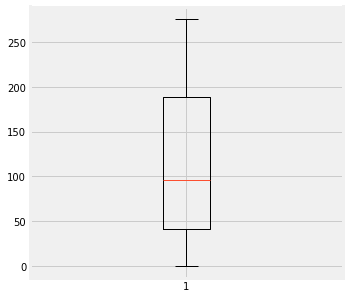

In [149]:
# plotting distribution of length of tweets post data wrangling
fig, ax = plt.subplots(figsize=(5, 5))
plt.boxplot(df.post_clean_len)
plt.show()

In [150]:
#dropping columns from dataset that are not required for further analysis 
df.drop(columns=['username', 'pre_clean_len','post_clean_len'], inplace= True)
df.shape

(28854, 5)

In [151]:
#aggregating fields by timestamp 'date'
df = df.groupby(['date'], as_index = False).agg({'tweet': ''.join, 'replies_count': "sum", 'retweets_count': "sum",'likes_count':"sum"}, Inplace=True)
df.head()

,date,tweet,replies_count,retweets_count,likes_count
0,2020-01-01 08:32:00,almost as useless as your tweet about btc bein...,1,0,2
1,2020-01-01 11:30:00,in the reports account for it as the value of ...,1,0,3
2,2020-01-01 14:51:00,good eye yes used the original formula btc sf ...,5,5,88
3,2020-01-01 15:29:00,that great congrats gaurav are you able to set...,2,0,1
4,2020-01-01 22:09:00,no because it has not established oscillation ...,3,2,10


In [152]:
#computing sentiment metrics of tweet usign vader library available as python package
df['Comp'] = ''
df['Negative'] = ''
df['Neutral'] = ''
df['Positive'] = ''

import nltk
nltk.download('vader_lexicon')

from nltk.sentiment.vader import SentimentIntensityAnalyzer
import unicodedata
sentiment_i_a = SentimentIntensityAnalyzer()
for indexx, row in df.T.iteritems():
    try:
        sentence_i = unicodedata.normalize('NFKD', df.loc[indexx, 'tweet'])
        sentence_sentiment = sentiment_i_a.polarity_scores(sentence_i)
        df.at[indexx, 'Comp'] = sentence_sentiment['compound']
        df.at[indexx, 'Negative'] = sentence_sentiment['neg']
        df.at[indexx, 'Neutral'] = sentence_sentiment['neu']
        df.at[indexx, 'Positive'] = sentence_sentiment['pos']
    except TypeError:
        print (df.loc[indexx, 'tweet'])
        print (indexx)

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [153]:
#visualising dataset post creation of sentiment metrics
df.head()

,date,tweet,replies_count,retweets_count,likes_count,Comp,Negative,Neutral,Positive
0,2020-01-01 08:32:00,almost as useless as your tweet about btc bein...,1,0,2,0.3774,0.135,0.644,0.22
1,2020-01-01 11:30:00,in the reports account for it as the value of ...,1,0,3,0.4588,0.065,0.787,0.149
2,2020-01-01 14:51:00,good eye yes used the original formula btc sf ...,5,5,88,0.802,0.079,0.669,0.251
3,2020-01-01 15:29:00,that great congrats gaurav are you able to set...,2,0,1,0.8176,0,0.717,0.283
4,2020-01-01 22:09:00,no because it has not established oscillation ...,3,2,10,-0.296,0.049,0.951,0


In [154]:
#adding constant value of 1 to social media metrics namely, 'replies_count', 'retweets_count', 'likes_count' for smoothening & computation of text feature  
df['replies_count'] = df['replies_count'] + 1 
df['retweets_count'] = df['retweets_count'] + 1 
df['likes_count'] = df['likes_count'] + 1 
df['Comp'] = df['Comp']+1
df.head()

,date,tweet,replies_count,retweets_count,likes_count,Comp,Negative,Neutral,Positive
0,2020-01-01 08:32:00,almost as useless as your tweet about btc bein...,2,1,3,1.3774,0.135,0.644,0.22
1,2020-01-01 11:30:00,in the reports account for it as the value of ...,2,1,4,1.4588,0.065,0.787,0.149
2,2020-01-01 14:51:00,good eye yes used the original formula btc sf ...,6,6,89,1.802,0.079,0.669,0.251
3,2020-01-01 15:29:00,that great congrats gaurav are you able to set...,3,1,2,1.8176,0,0.717,0.283
4,2020-01-01 22:09:00,no because it has not established oscillation ...,4,3,11,0.704,0.049,0.951,0


In [155]:
#we compute text feature required for further analysis, as a product of composite value derived from snetiment analysis alogside social media metrics such as 'replies_count', 'retweets_count', 'likes_count' 
df['text_feature']=df['Comp']*df['replies_count']*df['retweets_count']*df['likes_count']
df.head()

,date,tweet,replies_count,retweets_count,likes_count,Comp,Negative,Neutral,Positive,text_feature
0,2020-01-01 08:32:00,almost as useless as your tweet about btc bein...,2,1,3,1.3774,0.135,0.644,0.22,8.2644
1,2020-01-01 11:30:00,in the reports account for it as the value of ...,2,1,4,1.4588,0.065,0.787,0.149,11.6704
2,2020-01-01 14:51:00,good eye yes used the original formula btc sf ...,6,6,89,1.802,0.079,0.669,0.251,5773.61
3,2020-01-01 15:29:00,that great congrats gaurav are you able to set...,3,1,2,1.8176,0,0.717,0.283,10.9056
4,2020-01-01 22:09:00,no because it has not established oscillation ...,4,3,11,0.704,0.049,0.951,0,92.928


In [156]:
#filtering fields that are required for further analysis 
df1= df.filter(items=['date', 'text_feature'])
df1.head()

,date,text_feature
0,2020-01-01 08:32:00,8.2644
1,2020-01-01 11:30:00,11.6704
2,2020-01-01 14:51:00,5773.61
3,2020-01-01 15:29:00,10.9056
4,2020-01-01 22:09:00,92.928


In [157]:
#reading file containing candlesticks data pulled from binance exchange between time period 15-08-2019 to 15-08-2021 at a minute level for Bitcoin(BTC)
df2= pd.read_csv('Binance_data_BTCUSDT_15 Aug, 2019_to_15 Aug, 2021_1m.csv')
#exploring dimensions of imported dataset
df2.shape

(1049773, 13)

In [158]:
#visualising dataset imported
df1.head()

,date,text_feature
0,2020-01-01 08:32:00,8.2644
1,2020-01-01 11:30:00,11.6704
2,2020-01-01 14:51:00,5773.61
3,2020-01-01 15:29:00,10.9056
4,2020-01-01 22:09:00,92.928


In [159]:
#parametres returned by api response from binance exchange
#0-   Open Time 
#1 -  Open Price
#2 -  High Price
#3 -  Low Price
#4 -  Close Price
#5 -  Volume of trades
#6 -  Close Time
#7 -  Quote asset volume 
#8 -  Number of trades 
#9 -  Taker Buy Base Asset Volume 
#10 - Taker Buy Quote Asset Volume 
#11 - Ignore

In [160]:
#we rename columns with names of the resective parameters 
df2.rename(columns={'0': 'Open_time', '1':'Open', '2':'High', '3':'Low', '4':'Close_BTC', '5':'Volume_BTC','6':'Close_time','7':'Quote asset volume','8':'Number_of_trades_BTC','9':'Taker buy base asset volume','10':'Taker buy quote asset volume','11': 'Ignore'}, inplace=True)
#we drop columns which are not required for further analysis, namely Open Price, High Price, Low Price, Quote Asset Volume, Taker Buy Base Asset Volume, Taker Buy Quote Asset Volume, Ignore 
df2.drop(columns=['Unnamed: 0','Open','High','Low','Close_time','Quote asset volume','Taker buy base asset volume','Taker buy quote asset volume','Ignore'], inplace=True)
#exploring dimensions of dataframe post dropping columns 
df2.shape

(1049773, 4)

In [161]:
#converting unixtime to readable time format
df2['Open_time'] = pd.to_datetime(df2['Open_time']/1000, unit='s')
#visualising dataset 
df2.head()


,Open_time,Close_BTC,Volume_BTC,Number_of_trades_BTC
0,2019-08-15 00:00:00,10144.54,114.720030,1459
1,2019-08-15 00:01:00,10132.25,409.414904,3443
2,2019-08-15 00:02:00,10132.19,118.248972,1028
3,2019-08-15 00:03:00,10149.31,36.480215,422
4,2019-08-15 00:04:00,10128.26,84.651933,747


In [162]:
#Renaming column Open_time to date for ease of use 
df2.rename(columns={'Open_time': 'date'}, inplace= True)
df2.head()

,date,Close_BTC,Volume_BTC,Number_of_trades_BTC
0,2019-08-15 00:00:00,10144.54,114.720030,1459
1,2019-08-15 00:01:00,10132.25,409.414904,3443
2,2019-08-15 00:02:00,10132.19,118.248972,1028
3,2019-08-15 00:03:00,10149.31,36.480215,422
4,2019-08-15 00:04:00,10128.26,84.651933,747


In [163]:
#creation of new column named close_360 mins which represents the price of bitcoin(BTC) 6 hours prior to current time   
df2['close_360min'] = df2.Close_BTC.shift(360)
df2.head()

,date,Close_BTC,Volume_BTC,Number_of_trades_BTC,close_360min
0,2019-08-15 00:00:00,10144.54,114.720030,1459,NaN
1,2019-08-15 00:01:00,10132.25,409.414904,3443,NaN
2,2019-08-15 00:02:00,10132.19,118.248972,1028,NaN
3,2019-08-15 00:03:00,10149.31,36.480215,422,NaN
4,2019-08-15 00:04:00,10128.26,84.651933,747,NaN


In [164]:
#type conversion of column Timestamp as a pandas time series element 
df2['date'] =  pd.to_datetime(df2['date'], format='%d/%m/%Y %H:%M')
df2.head()

,date,Close_BTC,Volume_BTC,Number_of_trades_BTC,close_360min
0,2019-08-15 00:00:00,10144.54,114.720030,1459,NaN
1,2019-08-15 00:01:00,10132.25,409.414904,3443,NaN
2,2019-08-15 00:02:00,10132.19,118.248972,1028,NaN
3,2019-08-15 00:03:00,10149.31,36.480215,422,NaN
4,2019-08-15 00:04:00,10128.26,84.651933,747,NaN


In [165]:
#dropping row entries that contain null value. null values are created as we shift time stamp by 6 hours to determine lagged values 
df2.dropna(inplace=True)
df2.head()

,date,Close_BTC,Volume_BTC,Number_of_trades_BTC,close_360min
360,2019-08-15 14:00:00,10034.93,32.579320,355,10144.54
361,2019-08-15 14:01:00,10063.10,34.863390,517,10132.25
362,2019-08-15 14:02:00,10065.28,83.969008,1088,10132.19
363,2019-08-15 14:03:00,10051.01,47.185592,519,10149.31
364,2019-08-15 14:04:00,10085.67,28.420858,328,10128.26


In [166]:
#creating a column named diff_360min which is indicative of price difference between current timestamp and 6 hours prior 
df2['diff_360min']= df2['close_360min'] - df2['Close_BTC'] 
df2.head()

,date,Close_BTC,Volume_BTC,Number_of_trades_BTC,close_360min,diff_360min
360,2019-08-15 14:00:00,10034.93,32.579320,355,10144.54,109.61
361,2019-08-15 14:01:00,10063.10,34.863390,517,10132.25,69.15
362,2019-08-15 14:02:00,10065.28,83.969008,1088,10132.19,66.91
363,2019-08-15 14:03:00,10051.01,47.185592,519,10149.31,98.30
364,2019-08-15 14:04:00,10085.67,28.420858,328,10128.26,42.59


In [167]:
#we create a new column named indicator_360min which accounts for up/downswing in prices comparing present close price and close price 6 hours prior. Upswings are represented as '1' and downswings are represented as '0' 
df2['indicator_360min'] = np.where(df2['diff_360min'] > 0, 1, 0)
df2.head()

,date,Close_BTC,Volume_BTC,Number_of_trades_BTC,close_360min,diff_360min,indicator_360min
360,2019-08-15 14:00:00,10034.93,32.579320,355,10144.54,109.61,1
361,2019-08-15 14:01:00,10063.10,34.863390,517,10132.25,69.15,1
362,2019-08-15 14:02:00,10065.28,83.969008,1088,10132.19,66.91,1
363,2019-08-15 14:03:00,10051.01,47.185592,519,10149.31,98.30,1
364,2019-08-15 14:04:00,10085.67,28.420858,328,10128.26,42.59,1


In [168]:
df2 = df2.filter(items=['date', 'Close_BTC','Volume_BTC','Number_of_trades_BTC','indicator_360min'])
df2.head()

,date,Close_BTC,Volume_BTC,Number_of_trades_BTC,indicator_360min
360,2019-08-15 14:00:00,10034.93,32.579320,355,1
361,2019-08-15 14:01:00,10063.10,34.863390,517,1
362,2019-08-15 14:02:00,10065.28,83.969008,1088,1
363,2019-08-15 14:03:00,10051.01,47.185592,519,1
364,2019-08-15 14:04:00,10085.67,28.420858,328,1


In [169]:
#adding a constant value of 1 to fields'Voume_BTC', 'Number_of_trades_BTC' for smoothening 
df2['Volume_BTC'] = df2['Volume_BTC']+1
df2['Number_of_trades_BTC'] = df2['Number_of_trades_BTC']+1

In [170]:
#merging numerical and tweet dataset, to create a final dataset which can then be used for analysis
df = pd.merge(df2, df1, how='inner', on='date')
df.shape

(27480, 6)

In [171]:
#visualising dataset created for modelling
df.head()

,date,Close_BTC,Volume_BTC,Number_of_trades_BTC,indicator_360min,text_feature
0,2020-01-01 08:32:00,7190.57,12.043702,103,1,8.2644
1,2020-01-01 11:30:00,7231.05,19.914479,276,0,11.6704
2,2020-01-01 14:51:00,7221.50,18.900408,192,0,5773.61
3,2020-01-01 15:29:00,7228.13,10.952466,125,0,10.9056
4,2020-01-01 22:09:00,7219.85,10.854588,193,1,92.928


In [172]:
#check if ther there null values in our dataset
df.isnull().sum()

date                    0
Close_BTC               0
Volume_BTC              0
Number_of_trades_BTC    0
indicator_360min        0
text_feature            0
dtype: int64

In [173]:
#check on value distribution of dependent variable, 'indicator_360min' if there exists an imbalance in dataset 
df['indicator_360min'].value_counts()

0    15273
1    12207
Name: indicator_360min, dtype: int64

In [174]:
df=df[['date','Close_BTC','Volume_BTC','Number_of_trades_BTC','text_feature','indicator_360min']]
df.head()

,date,Close_BTC,Volume_BTC,Number_of_trades_BTC,text_feature,indicator_360min
0,2020-01-01 08:32:00,7190.57,12.043702,103,8.2644,1
1,2020-01-01 11:30:00,7231.05,19.914479,276,11.6704,0
2,2020-01-01 14:51:00,7221.50,18.900408,192,5773.61,0
3,2020-01-01 15:29:00,7228.13,10.952466,125,10.9056,0
4,2020-01-01 22:09:00,7219.85,10.854588,193,92.928,1


In [175]:
#extracting time metrics from timestamp, so as to be passed to model as parameters 
df['day'] = df['date'].dt.day
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year
df['hour']=df['date'].dt.hour
df['minute']= df['date'].dt.minute
df.head()

,date,Close_BTC,Volume_BTC,Number_of_trades_BTC,text_feature,indicator_360min,day,month,year,hour,minute
0,2020-01-01 08:32:00,7190.57,12.043702,103,8.2644,1,1,1,2020,8,32
1,2020-01-01 11:30:00,7231.05,19.914479,276,11.6704,0,1,1,2020,11,30
2,2020-01-01 14:51:00,7221.50,18.900408,192,5773.61,0,1,1,2020,14,51
3,2020-01-01 15:29:00,7228.13,10.952466,125,10.9056,0,1,1,2020,15,29
4,2020-01-01 22:09:00,7219.85,10.854588,193,92.928,1,1,1,2020,22,9


In [176]:
#dropping column 'date', as its not required for further analysis
df.drop(columns=['date'], inplace= True)
df.head()

,Close_BTC,Volume_BTC,Number_of_trades_BTC,text_feature,indicator_360min,day,month,year,hour,minute
0,7190.57,12.043702,103,8.2644,1,1,1,2020,8,32
1,7231.05,19.914479,276,11.6704,0,1,1,2020,11,30
2,7221.50,18.900408,192,5773.61,0,1,1,2020,14,51
3,7228.13,10.952466,125,10.9056,0,1,1,2020,15,29
4,7219.85,10.854588,193,92.928,1,1,1,2020,22,9


In [177]:
#import library for creating train and test set
from sklearn.model_selection import train_test_split

In [178]:
#we create train and test set of ratio 0.8:0.2
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['indicator_360min']), df['indicator_360min'], test_size=0.2, random_state=42)

In [179]:
#exploring value distribution of dependent variable on train set 
y_train.value_counts()

0    12152
1     9832
Name: indicator_360min, dtype: int64

In [180]:
#exploring value distribution of dependent variable on test set 
y_test.value_counts()

0    3121
1    2375
Name: indicator_360min, dtype: int64

In [181]:
#importing ensemble model random forest classifier for modelling 
from sklearn.ensemble import RandomForestClassifier
classifier=RandomForestClassifier()

In [182]:
#fit train data 
classifier.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [183]:
#import necessary libraries for cross validation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

In [184]:
#building an function to evaluate k_fold validation score
def evaluate_model(X, y, model):
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
    return scores

In [185]:
score_k_fold = evaluate_model(X_train, y_train, classifier)

In [186]:
score_k_fold

array([0.77689334, 0.78371617, 0.78712759, 0.78189675, 0.78139217,
       0.77439163, 0.77666591, 0.78371617, 0.78962929, 0.78730664,
       0.77916761, 0.78348874, 0.7839436 , 0.77780305, 0.77979982])

In [187]:
#computing mena of k_fold validation score 
score_k_fold.mean()

0.7817958986981295

In [188]:
#predicting values of test set 
prediction=classifier.predict(X_test)

In [189]:
#classification report
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
print(confusion_matrix(y_test,prediction))
print(accuracy_score(y_test,prediction))
print(classification_report(y_test,prediction))

[[2727  394]
 [ 640 1735]]
0.8118631732168851
              precision    recall  f1-score   support

           0       0.81      0.87      0.84      3121
           1       0.81      0.73      0.77      2375

    accuracy                           0.81      5496
   macro avg       0.81      0.80      0.81      5496
weighted avg       0.81      0.81      0.81      5496



In [190]:
#hyper parameter tuning ensemble model built 
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [126]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 21.3min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 95.1min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 172.7min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [127]:
print(rf_random.best_params_)

{'n_estimators': 1000, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 50, 'bootstrap': False}


In [191]:
#building ensemble model using idetified best parameters
bst_classifier=RandomForestClassifier(n_estimators=1000,min_samples_split=2,min_samples_leaf=1,max_depth=50, bootstrap= False)

In [192]:
#performing cross valdiation
score_k_fold = evaluate_model(X_train, y_train, bst_classifier)

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [193]:
score_k_fold

array([0.81896748, 0.8166932 , 0.82010462, 0.8207869 , 0.82165605,
       0.80987037, 0.81646577, 0.81419149, 0.82306118, 0.82870792,
       0.81964976, 0.82556288, 0.81464635, 0.81487378, 0.82120109])

In [194]:
score_k_fold.mean()

0.8190959224480198

In [195]:
#fit train data 
bst_classifier.fit(X_train,y_train)

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=50, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [196]:
#predicting test set 
prediction=bst_classifier.predict(X_test)

In [197]:
#classification report 
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
print(confusion_matrix(y_test,prediction))
print(accuracy_score(y_test,prediction))
print(classification_report(y_test,prediction))

[[2769  352]
 [ 474 1901]]
0.8497088791848617
              precision    recall  f1-score   support

           0       0.85      0.89      0.87      3121
           1       0.84      0.80      0.82      2375

    accuracy                           0.85      5496
   macro avg       0.85      0.84      0.85      5496
weighted avg       0.85      0.85      0.85      5496

